# Time Series Analysis

**Introduction**

In this notebook, we will:
1. Narrow down our analysis to focus on one stock, Facebook.
2. Understand the changes of FB stock prices on each month.
3. Predict future stock prices

Data source: Yahoo
Using pandas datareader, I will get stock information for the FAANG tech companies:
* Facebook (FB)
* Apple (AAPL)
* Amazon (AMZN)
* Netflix (NFLX)
* Google (GOOGL)

In [8]:
import pandas_datareader
from pandas_datareader import data, wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


### Part 1: Load data

In [9]:
start = datetime.datetime(2012, 5, 18) #when FB IPO
end = datetime.datetime(2020, 1, 1)

#Facebook
FB = data.DataReader("FB","yahoo",start,end)
FB.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [16]:
FB = FB.reset_index()
#Create new variables - average stocks price per month
FB['Month'] = FB['Date'].apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
FB['Month'] = pd.to_datetime(FB['Month'])
FB.head()

,index,Date,High,Low,Open,Close,Volume,Adj Close,Month
0,0,2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000,2012-05-01
1,1,2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999,2012-05-01
2,2,2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000,2012-05-01
3,3,2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000,2012-05-01
4,4,2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999,2012-05-01


In [19]:
FB_bymonths = FB.groupby(['Month']).mean()
FB_bymonths.head()

,index,High,Low,Open,Close,Volume,Adj Close
Month,,,,,,,
2012-05-01,4.0,33.868889,31.057778,33.015556,31.870000,1.390570e+08,31.870000
2012-06-01,19.0,30.232381,28.893333,29.537143,29.540476,3.180526e+07,29.540476
2012-07-01,40.0,29.598095,28.437619,29.143333,28.880000,2.477094e+07,28.880000
2012-08-01,62.0,20.644783,19.768696,20.287391,20.108261,5.008456e+07,20.108261
2012-09-01,83.0,21.089474,20.170526,20.629474,20.627895,5.571809e+07,20.627895


### Part 2: Perform Dickey-Fuller test

In [20]:
#Define a function that performs Dickey-Fuller test and plot the moving average/moving std:

def DF_test(data, winnum):
    dftest = adfuller(data, autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)
    
    rolmean = data.rolling(window=winnum).mean()
    rolstd = data.rolling(window=winnum).std()

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    mean = ax.plot(rolmean, color='red',label='Rolling mean')
    std = ax.plot(rolstd, color = 'black',label ='Rolling std')
    org = ax.plot(data, color='blue', label ='Original')

    plt.title('Rolling mean and standard deviation')
    plt.legend(loc= 'best')
    plt.show(block=False)

Results of Dickey-Fuller test:
Test Statistic          -0.357816
p-value                  0.916907
#Lags Used               1.000000
Num of obs              91.000000
Critical Value (1%)     -3.504343
Critical Value (5%)     -2.893866
Critical Value (10%)    -2.584015
dtype: float64


<Figure size 1440x720 with 0 Axes>

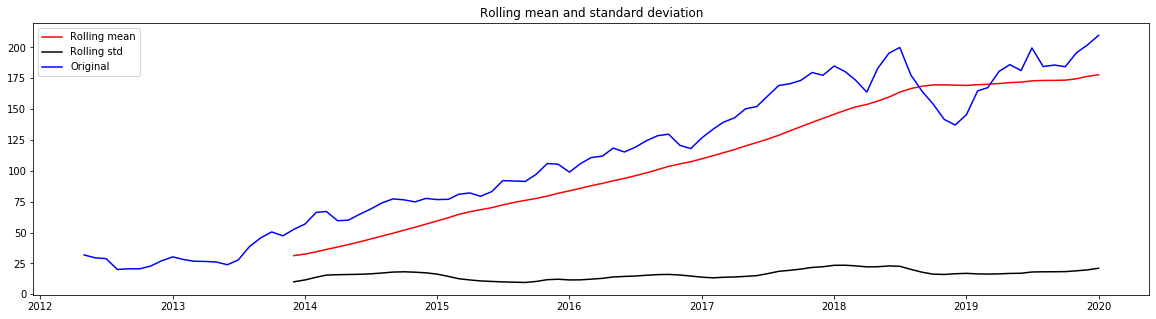

In [21]:
DF_test(FB_bymonths['Close'], 20)

High p-value indicates that the data is not stationary.

### Trend decomposition

In [32]:
FB_log = np.log(FB_bymonths['Close'])

FB_log = FB_log.dropna()
FB_log.shape

(93,)

Results of Dickey-Fuller test:
Test Statistic          -2.603498
p-value                  0.092276
#Lags Used               3.000000
Num of obs              89.000000
Critical Value (1%)     -3.506057
Critical Value (5%)     -2.894607
Critical Value (10%)    -2.584410
dtype: float64


<Figure size 1440x720 with 0 Axes>

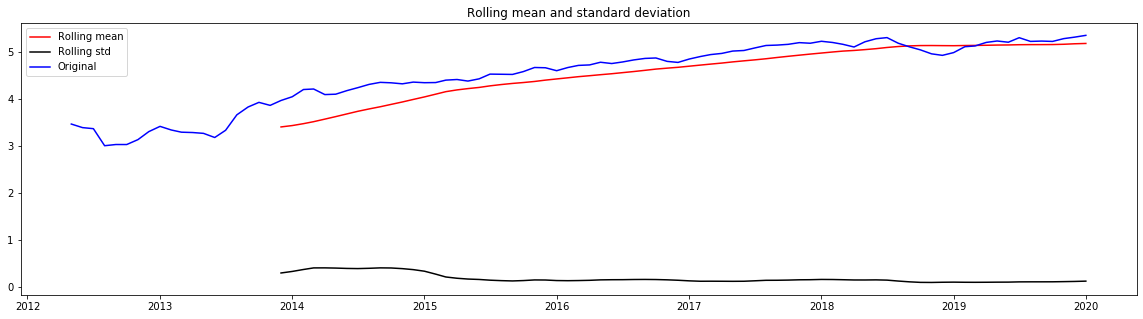

In [22]:

#Check DF test with this new variable
DF_test(FB_log,20)

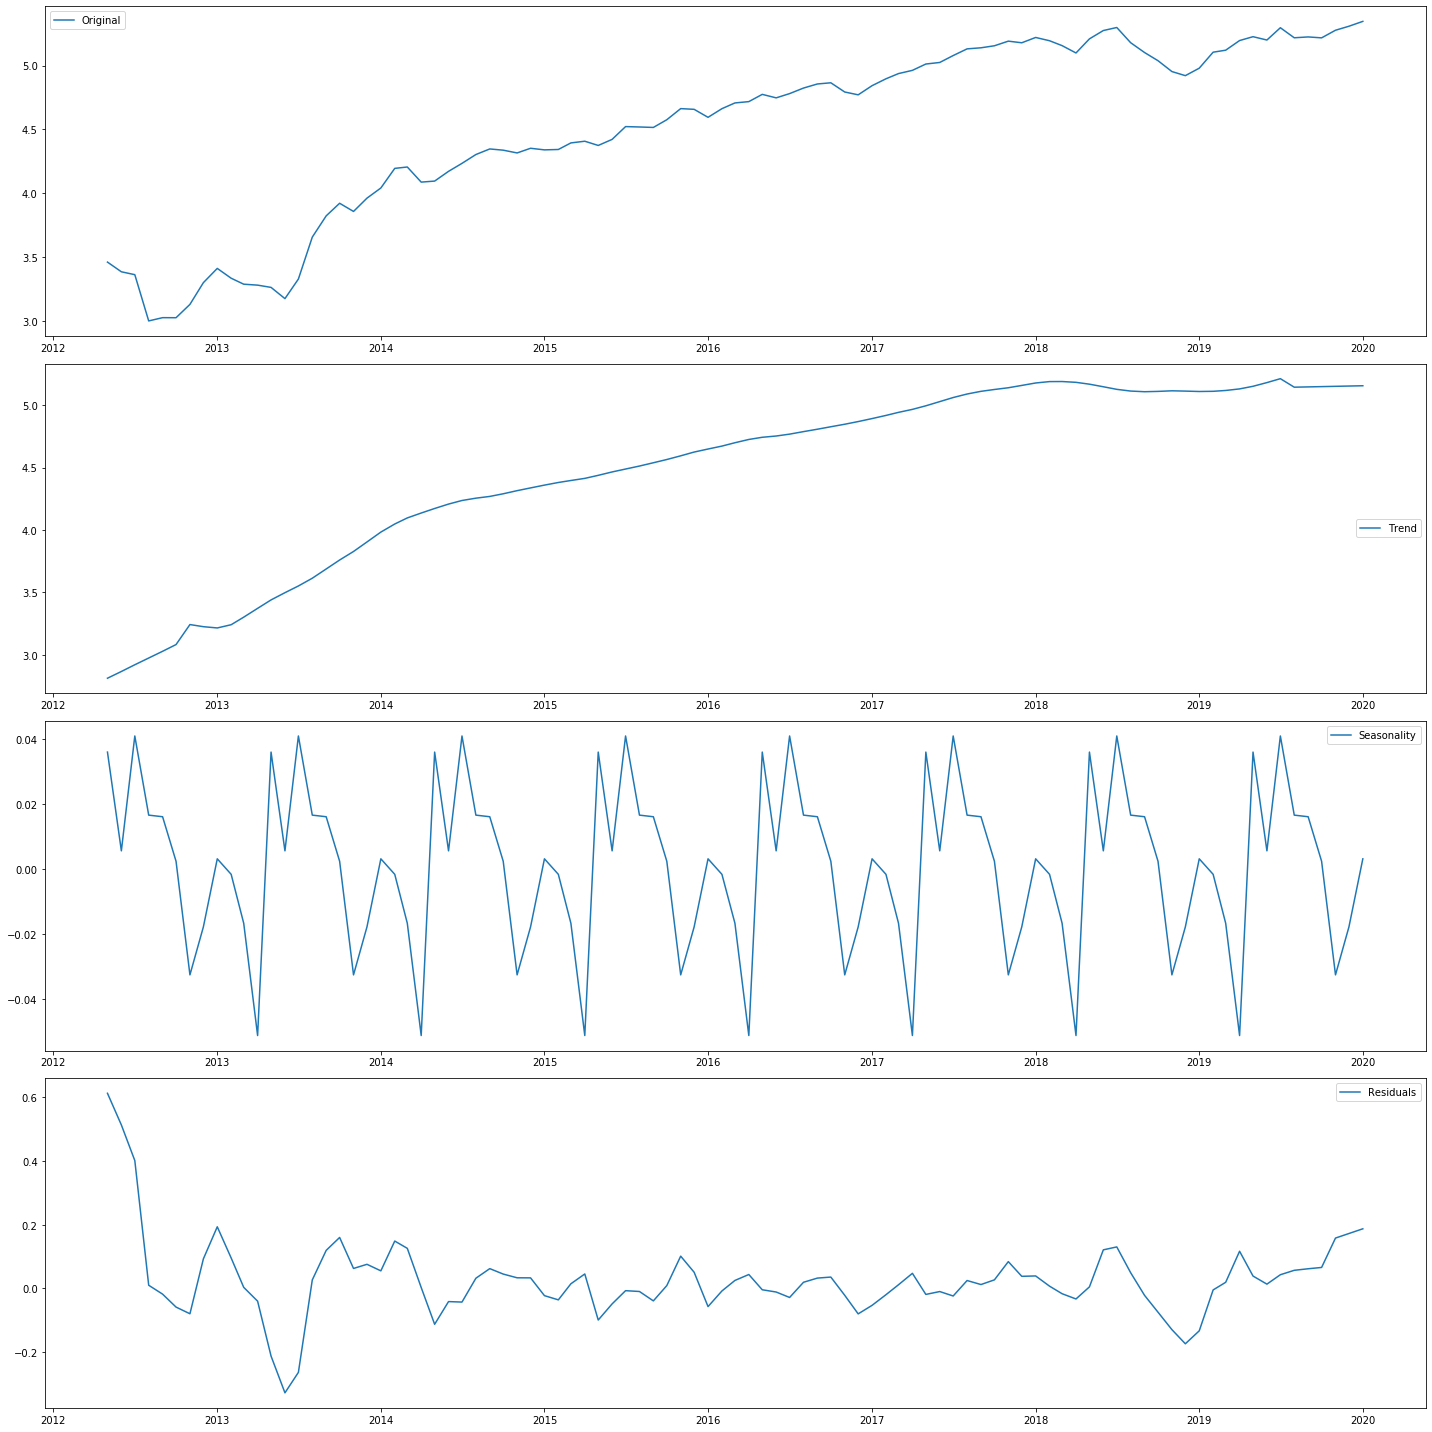

In [33]:
decomposition = seasonal_decompose(FB_log,model='additive',freq=12, extrapolate_trend = 12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 20))

plt.subplot(411)
plt.plot(FB_log,label='Original')
plt.legend(loc= 'best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='center right')

plt.subplot(413)
plt.plot(seasonal, label ='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

It is clear that the trend of FB stocks is increasing. It seems to be seasonal (a season seems to be half a year).

Results of Dickey-Fuller test:
Test Statistic          -4.648683
p-value                  0.000105
#Lags Used              10.000000
Num of obs              82.000000
Critical Value (1%)     -3.512738
Critical Value (5%)     -2.897490
Critical Value (10%)    -2.585949
dtype: float64


<Figure size 1440x720 with 0 Axes>

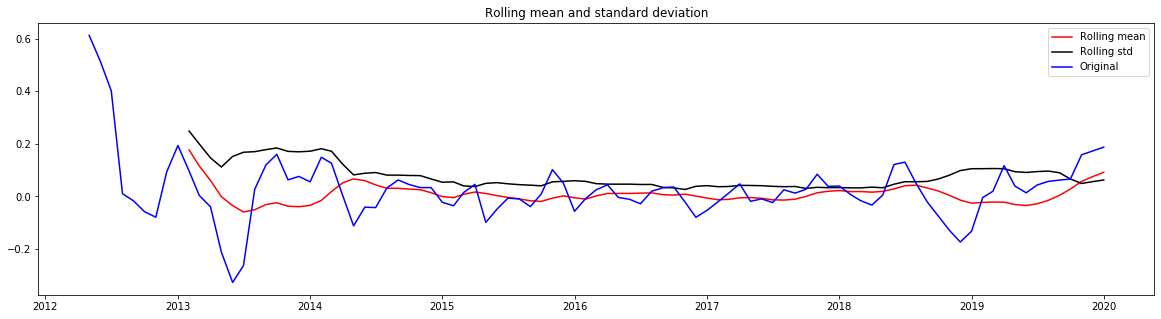

In [34]:
decomposedLogData = residual
DF_test(decomposedLogData,10)

The decomposed data is stationary. The rolling std is almost flat though the moving average is not quite.

### Part 3: ARIMA Model and predictions

**Autocorrelation function**

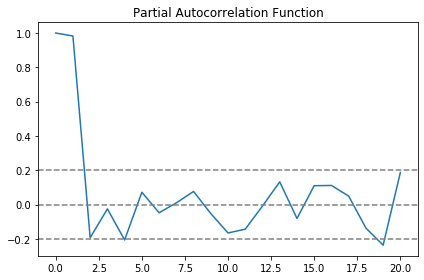

In [35]:
#Plot pacf - partial autocorrelation function
from statsmodels.tsa.stattools import pacf

lag_pacf = pacf(FB_log, nlags = 20)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(FB_log)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(FB_log)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

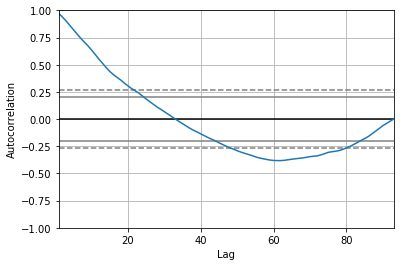

In [36]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(FB_log)
#plt.xlabel('Lag')

The number of lags are very huge if we analyze time series data by days. But we will continue and later on compare the two methods.

**ARIMA (Auto-regressive + Moving-average)**

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and. q is the number of lagged forecast errors in the prediction equation. ACF can be used to figure out the best order of the MA model and PACF can be used to find the best order of AR model.
Check out for more details of choosing the orders: https://people.duke.edu/~rnau/411arim2.htm

Results of Dickey-Fuller test:
Test Statistic         -6.066915e+00
p-value                 1.175782e-07
#Lags Used              1.000000e+00
Num of obs              9.000000e+01
Critical Value (1%)    -3.505190e+00
Critical Value (5%)    -2.894232e+00
Critical Value (10%)   -2.584210e+00
dtype: float64


<Figure size 1440x720 with 0 Axes>

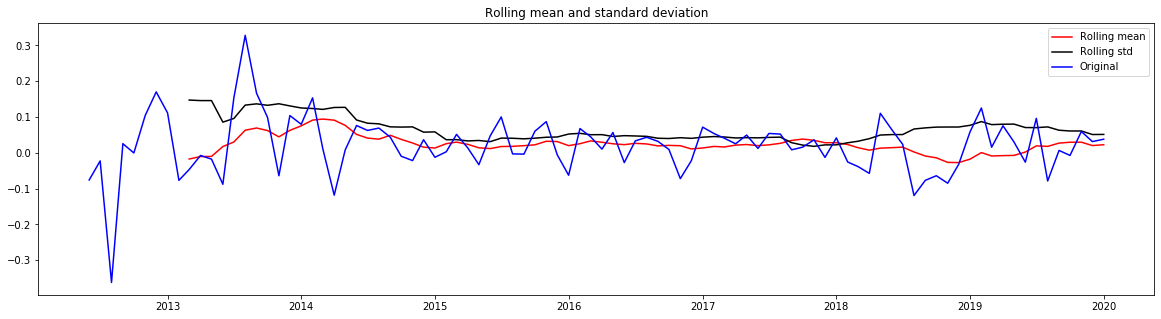

In [37]:
#Select data difference
FB_diffshift = FB_log - FB_log.shift().fillna(0)

FB_diffshift = FB_diffshift[1:]
#Check DF test
DF_test(FB_diffshift,10)


This new variable is stationary.

In [53]:
def plot_RSS(model_name, results_data):
    plt.figure(figsize=(20,7))
    fitted_values = results_data.fittedvalues
    plt.plot(FB_diffshift, label='True value changes')
    plt.plot(fitted_values, color='red', label='Fitted value changes')
    plt.legend(loc='best')
    plt.title(model_name+' Model'+' | RSS: %.4f'% sum((fitted_values - FB_diffshift).dropna()**2),fontsize =20)
    plt.tight_layout()

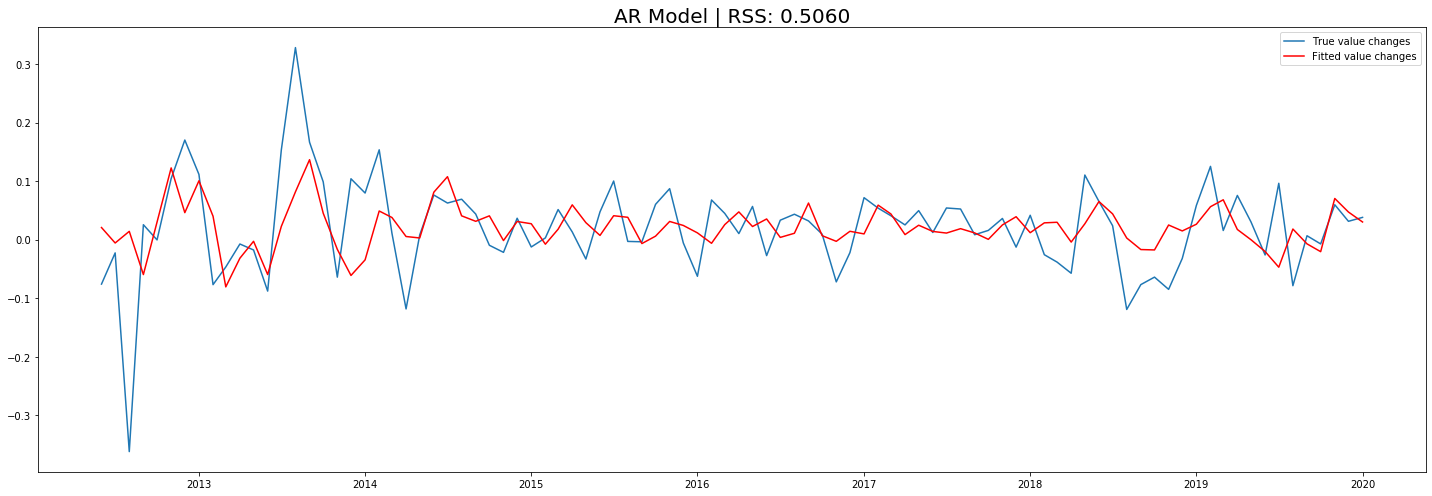

In [56]:
#AR model (q = 0)

model = ARIMA(FB_log, order= [10,1,0])
results_AR = model.fit()

plot_RSS('AR', results_AR)

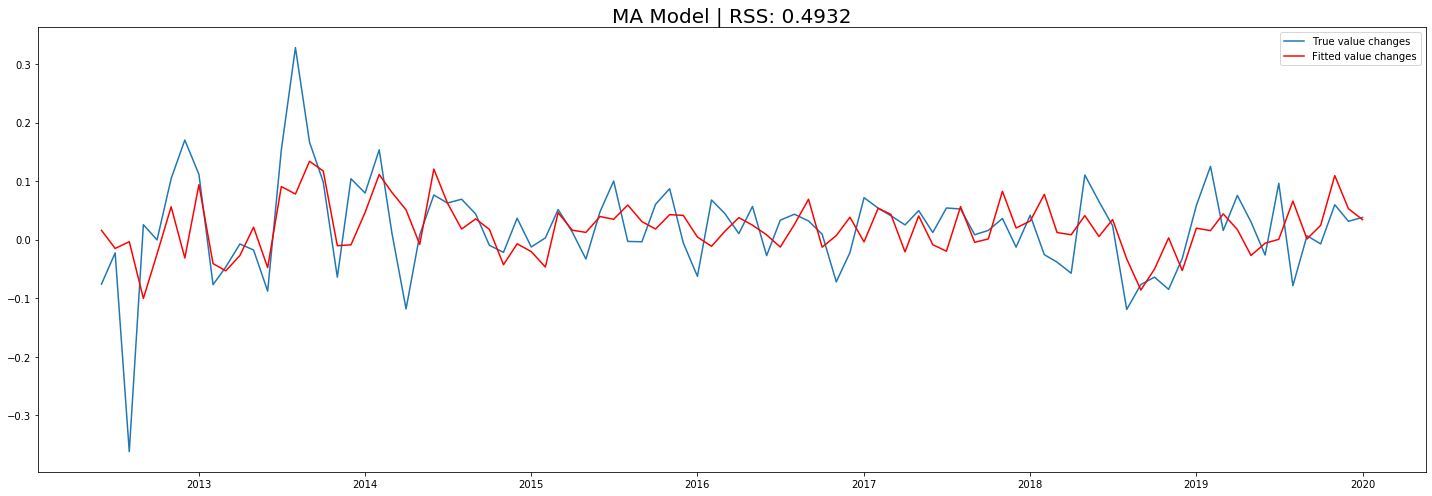

In [59]:
#MA model (p =0)

model = ARIMA(FB_log, order= [0,1,10])
results_MA = model.fit()

plot_RSS('MA', results_MA)

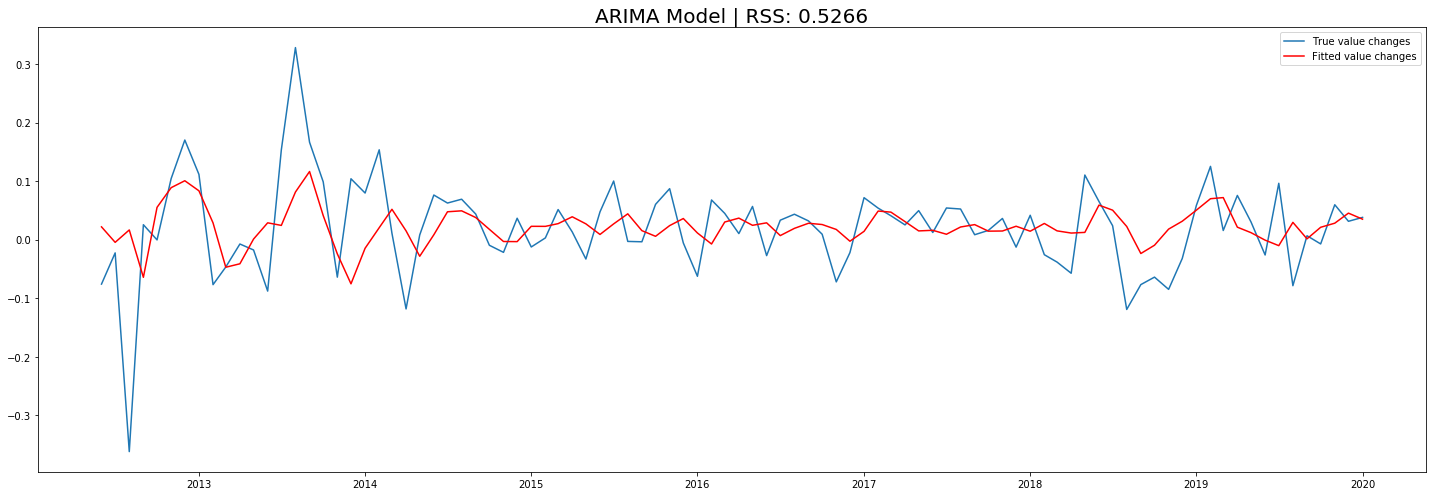

In [67]:
# ARIMA Model
model = ARIMA(FB_log, order= (2,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA)

### Give predictions

Compare ARIMA and AR models

1. ARIMA

In [68]:
def plot_predictions_of_diff(model_name, results_data):
    fitted_values = results_data.fittedvalues
    predictions_diff = pd.Series(fitted_values,copy=True)
    plt.figure(figsize=(20,5))
    plt.plot(predictions_diff)
    plt.title('Predicted value changes for '+ model_name)

In [78]:
#Convert it to actual terms

def convert_and_plot_actual_pred(model_name, results_data, forecast_range_inmonths):
    #Plot original and predicted values
    fitted_values = results_data.fittedvalues
    predictions_diff = pd.Series(fitted_values,copy=True)
    predictions_diff_cumsum = predictions_diff.cumsum()

    predictions_log= FB_log.add(predictions_diff_cumsum,fill_value=0)
    #predictions_log= FB_train.add(predictions_diff,fill_value=0)
    predictions = np.exp(predictions_log)
    
    plt.figure(figsize = (20,7))
    plt.plot(FB_bymonths['Close'], label='Original')
    plt.plot(predictions, label='Predicted by '+model_name)
    plt.legend(loc='best')
    
    #Plot future predictions
    number_days_ahead = 93 +  forecast_range_inmonths #93 is total months in our dataset
    fig, ax = plt.subplots(figsize=(20,10))
    results_data.plot_predict(1,number_days_ahead, ax=ax,alpha=0.05)

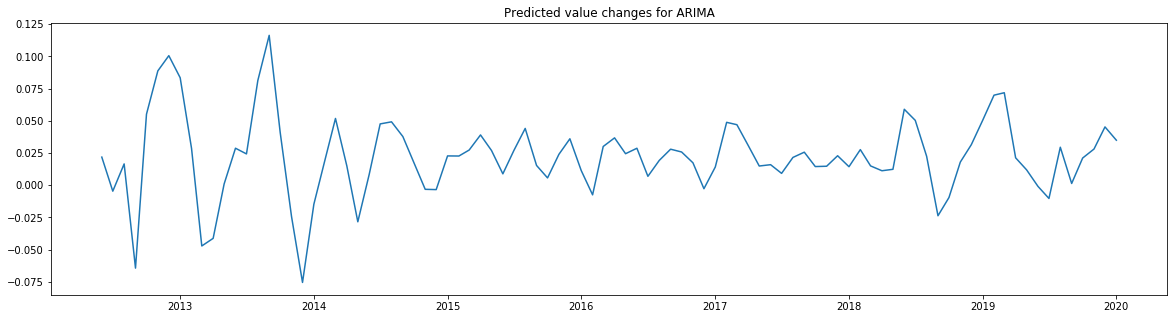

In [69]:
plot_predictions_of_diff('ARIMA', results_ARIMA)

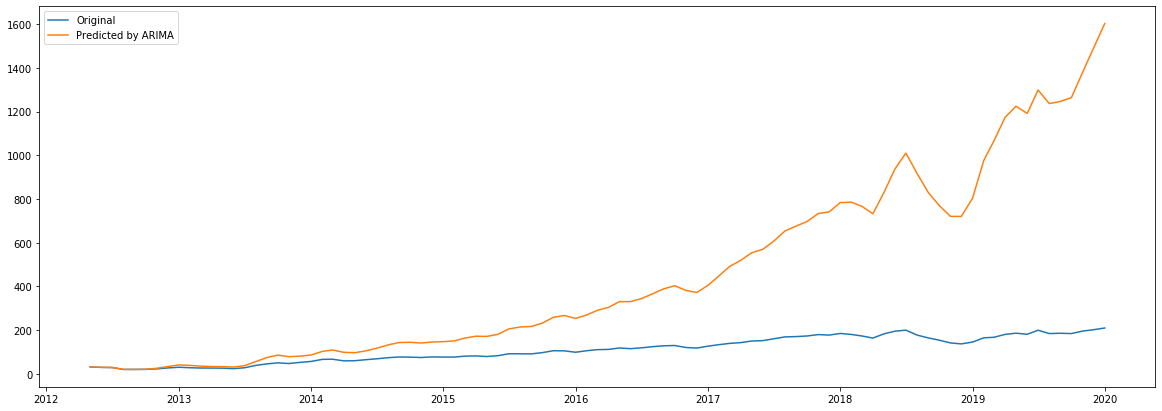

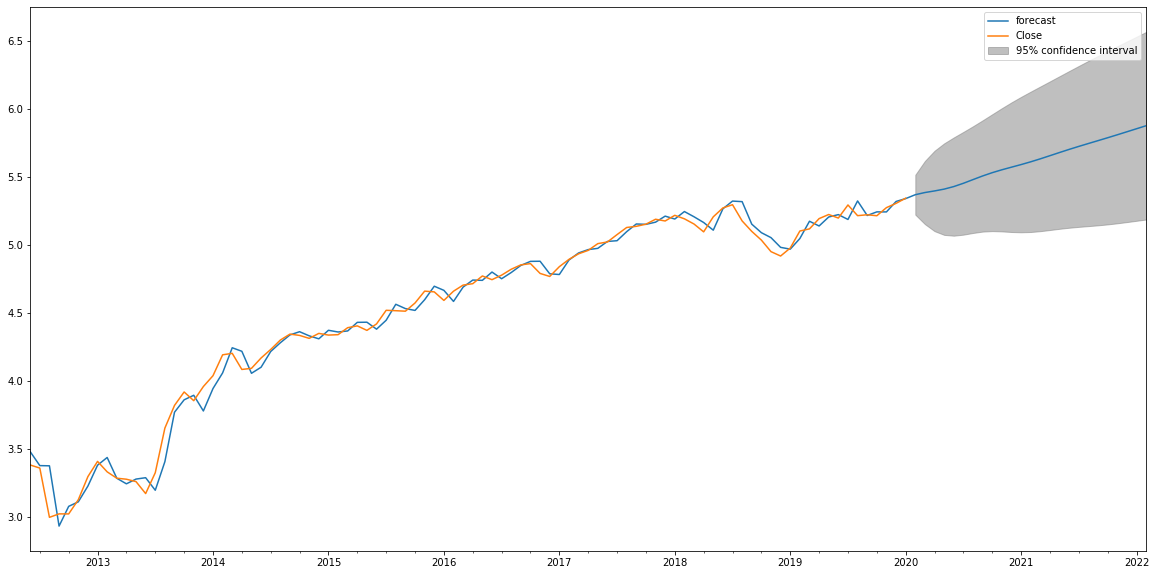

In [79]:
convert_and_plot_actual_pred('ARIMA', results_ARIMA, 24)

2. AR

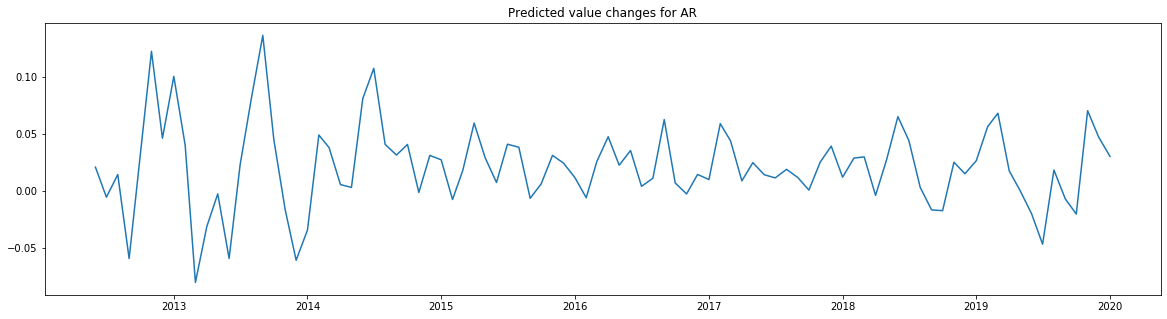

In [80]:
plot_predictions_of_diff('AR', results_AR)

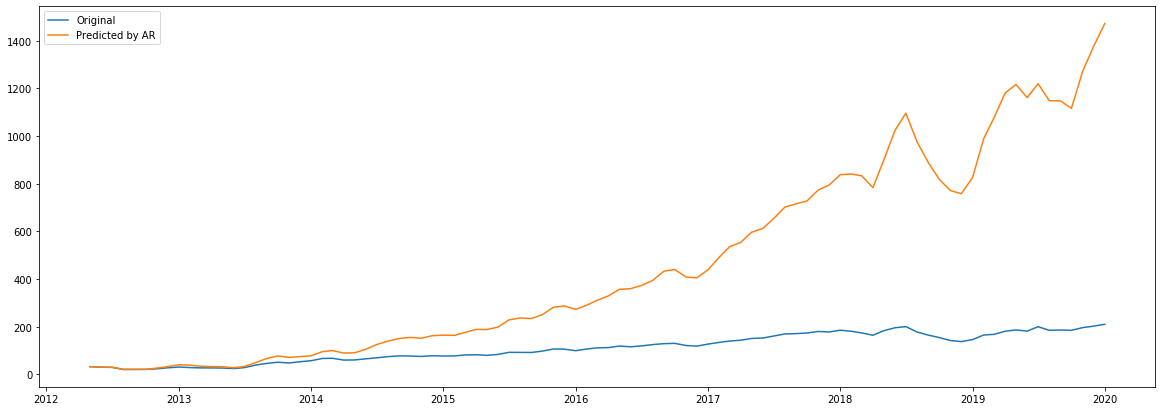

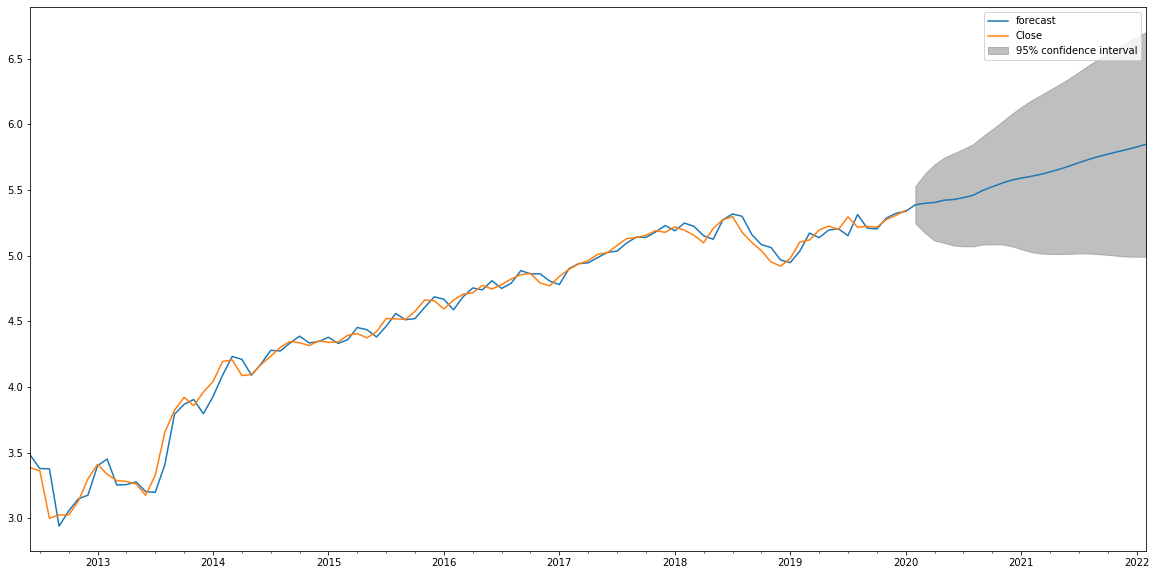

In [81]:
convert_and_plot_actual_pred('AR', results_AR, 24)

3. MA

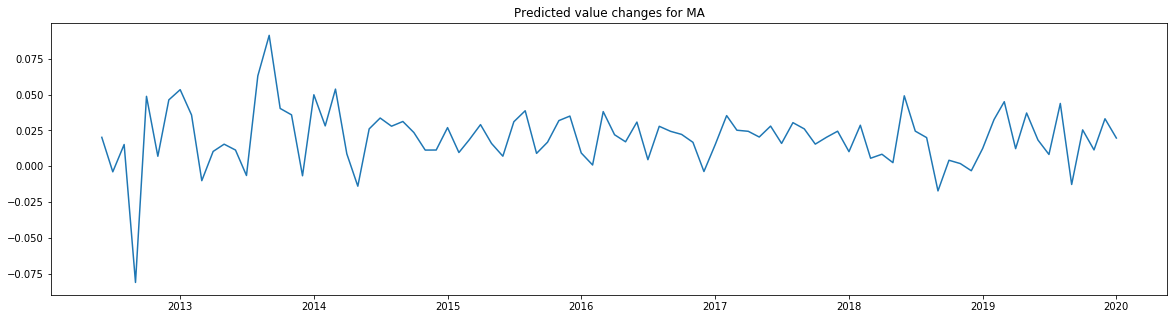

In [84]:
plot_predictions_of_diff('MA', results_MA)

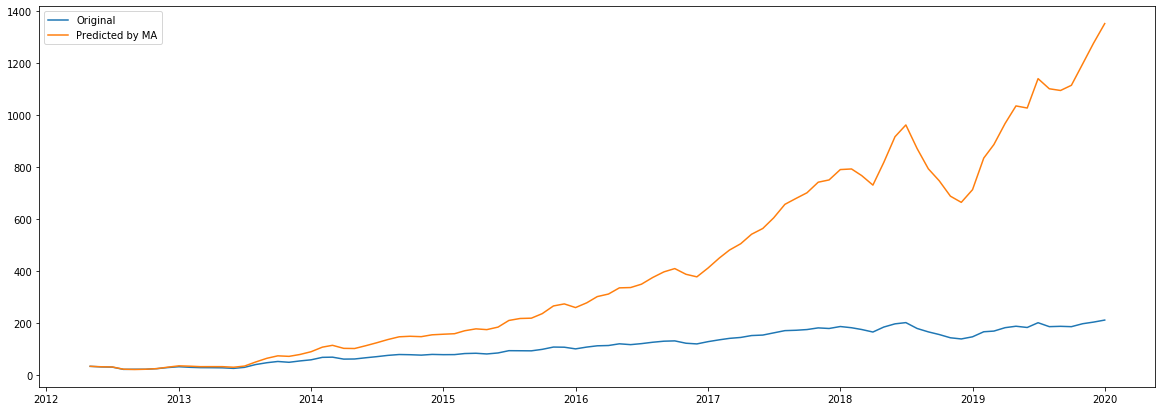

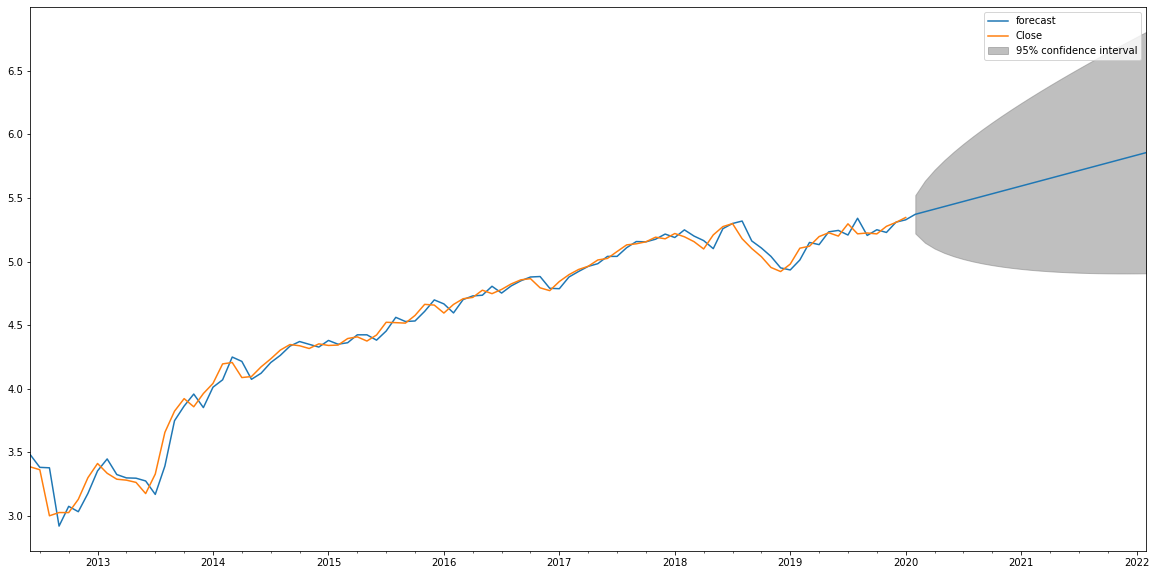

In [85]:
convert_and_plot_actual_pred('MA', results_MA, 24)

The moving average model seems to perform the best in this case.

### Conclusion

1. The results given when doing analysis by months is more robust (lower p-value, lower RSS, etc.)
2. Analyze stock prices by months makes a lot more sense.
2. Facebook stock price is predicted to continue to increase in the next two years.

This notebook creates a baseline model that can be applied to predict the future of any stocks.